## Strategy Idea 1 : "BSP Hedging"

__Section 0: Setup__ Importing packages/reading in data etc.

__Section 1 : Idea__ 

- __1.1__ Strategy idea

- __1.2__ Origin of idea. Context/Reasoning for strategy to work e.g. use in financial markets?

__Section 2 : Exploration__

- __2.1__ Exploratory Data Analysis. e.g plots of price/volumes that could show strategy working, how much potential.

- __2.2__ Define some 'strategy metrics'. Metrics that can can you use to gauge if this strategy will work i.e no.price points above a certain threshold that is profitable. Metrics could show how often there is an opportunity to make a trade and how much 'value' is in an opportunity e.g. how much is there a price swing?

__Section 3 : Practical requirements__

- __3.1__ Identify if this edge is ‘realisable’? What methods will you apply to extract this value? e.g. applying a hedge function


- __3.2__ Is it possible to quantify the potential profit from the strategy? Consideration : How long will it take to obtain this? How 'risky' is it? e.g. if something did go wrong, how much do we lose? 

- __3.3__ Strategy limitations. The factors that could prevent strategy working e.g. practical considerations e.g. reacting quick enough to market updates, volume behind a price, size of bankroll needed


__Section 4: Potential limitations__

- __4.1__ What is our 'competition' - if not quantifiable, do we suspect people are doing the same thing? 

- __4.2__ So what's our edge? Identify ways of finding this edge in future? e.g what features are there? Are they predictive? Is there a certain 'market/runner' profile?

__Section 5 : Strategy testing__

- __5.1__ Testing strategy on previous data. 

- __5.2__ State any assumptions made by testing.

- __5.3__ Model refinements. How could strategy be optimised? Careful : is this backfitting/overfitting - what measures taken to negate this e.g. bootstrapping?

- __5.4__ Assessing strategy. P/L on data sample? ROI? variance in results? longest losing run?



### Section 0 : Setup

In [1]:
# importing packages
from pathlib import Path, PurePath 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
# reading in data
project_dir = Path.cwd().parents[2]
data_dir = f"{project_dir}/data/processed/api/advanced/adv_data.csv"
df = pd.read_csv(data_dir, index_col = 0)
print(df.shape)
df.head()

(13073, 307)


,SelectionId,MarketId,Venue,Distance,RaceType,BSP,NoRunners,BS:T-60,BS:T-59,BS:T-58,...,LS:T+5,LS:T+6,LS:T+7,LS:T+8,LS:T+9,LS:T+10,LS:T+11,LS:T+12,LS:T+13,LS:T+14
0,11986132,1.169028,Huntingdon,20.0,Chase,8.33,9,16.43,24.51,26.57,...,10.08,11.15,5.44,7.09,14.16,19.53,3.12,3.31,0.68,0.68
1,16800725,1.169028,Huntingdon,20.0,Chase,3.68,9,15.43,25.74,57.82,...,29.87,221.22,43.23,43.10,13.53,26.15,13.60,74.30,419.52,23082.10
2,20968322,1.169028,Huntingdon,20.0,Chase,14.96,9,9.87,9.25,9.15,...,37.32,6.83,4.85,11.23,16.00,5.68,40.25,12.51,10.42,13.17
3,22023486,1.169028,Huntingdon,20.0,Chase,4.25,9,84.38,64.49,58.01,...,11.67,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02
4,24496216,1.169028,Huntingdon,20.0,Chase,6.60,9,10.64,10.11,7.91,...,34.27,54.72,11.85,17.99,48.21,17.28,38.29,6.96,4.37,4.37


In [9]:
# defining variables
back_prices = [col for col in df.columns if 'BP' in col]
back_sizes = [col for col in df.columns if 'BS' in col]
lay_prices = [col for col in df.columns if 'LP' in col]
lay_sizes = [col for col in df.columns if 'LS' in col]

runner_info = ['SelectionId', 'MarketId', 'Venue', 'Distance', 'RaceType', 'BSP', 'NoRunners']

In [146]:
def plot_df():
    plot_df = df[df['BSP'].notna()].sample(1).copy() # 60 NA BSP's

    bp_df = plot_df[['SelectionId'] + back_prices].copy()
    new_cols = bp_df.columns.str.replace("[BP:T]", "").str.replace("[+]", "")
    bp_df.rename(columns = dict(zip(bp_df.columns, new_cols)), inplace = True)
    bp_df = pd.melt(bp_df, id_vars = ['SelectionId'])
    bp_df['variable'] = bp_df['variable'].astype(int)

    lp_df = plot_df[['SelectionId'] + lay_prices].copy()
    new_cols = lp_df.columns.str.replace("[LP:T]", "").str.replace("[+]", "")
    lp_df.rename(columns = dict(zip(lp_df.columns, new_cols)), inplace = True)
    lp_df = pd.melt(lp_df, id_vars = ['SelectionId'])
    lp_df['variable'] = lp_df['variable'].astype(int)

    bsp_df = plot_df[['BSP']].copy()
    
    return bp_df, lp_df, bsp_df

### Section 1 : Idea

__1.1 Idea__

There is a large amount of price variation during __inplay__ markets in addition to high volumes of trading with £100,000-£200,000 (~20% of total matched per race) occurring during a race. I believe there is a profitable strategy to be had in back/laying a horse 'simultaneously at BSP and looking the 'hedge' this during a race. 

For example, backing a horse at BSP laying it higher inplay as well as laying at BSP and backing whilst inplay. Both yielding profitable hedge bets. Due to the amount of variation and the frequency at which this occurs (seems to be for large & of runners) with inplay prices, I suspect that there there is a large amount of potential to exploit this.

__1.2  Reasoning__

Why is there an edge here?
- Variation caused by a events that can happen within horse racing - anything can happen -> variations. e.g. a leader out in front all the way who then falls or a really close race where anyone can win it -> many price swings!
- Due to this in race 'unpredicatability' I believe there is a large amount of uncertainty of what the actua; price point is during the race, whilst the market price's the end result of the race as if it is 'easily estimated' but the minimum inplay overround ' says otherwise, meaning the inplay markets are very ineeficient. 

_Minimum Inplay overround : Taking the minimum price for every runner during a race and calculating the overround. There is a very high amount of overround 2X/3X that of a 'pre-race' market. Revealing that many runners in play are clearly priced inefficiently i.e. price != probability of winning the race._ High inplay overround/inefficiency has been identified in the `strategy_tests_old` notebooks.

### Section 2 : Exploration

__2.1__ Plots

To explore this phenomena (of price variation in comparison to BSP) plots of the back price and lay price throughout the time of race are shown below: 

__Plot of Back/Lay Price by Runner__

Taking a random runner from the sample and plotting their Back and Lay price over time. 

We are interested in how many time a horse's price goes above/below the red dotted line after Time == 0, when the race starts. The red dotted line displays the Betfair Starting Price which the back & lay price you can guarantee yourself before the start of the race.

Note : every time you run the cell a different runner will be chosen to plot - spam CTRL + ENTER

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 <a list of 8 Text major ticklabel objects>)

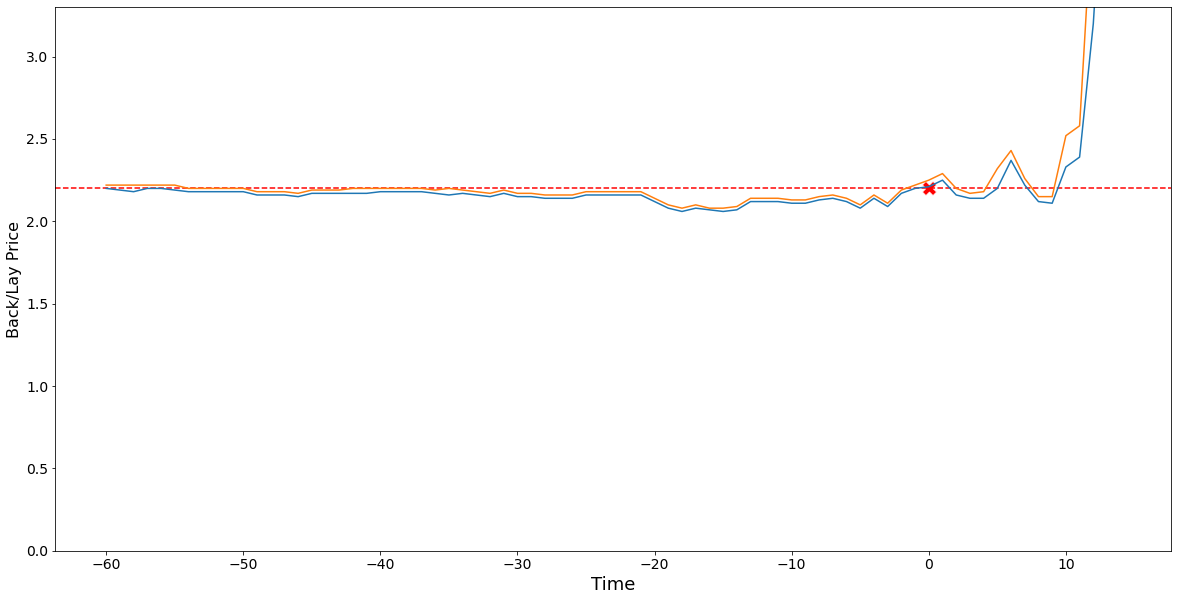

In [147]:
bp_df, lp_df, bsp_df = plot_df()

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, bsp_df['BSP'].item() * 1.5) # limit y axis

# plotting
sns.scatterplot(0, y = bsp_df['BSP'], marker = 'X', s=200, color = 'r')
plt.axhline(y=bsp_df['BSP'].item(), color='r', linestyle='--')

sns.lineplot(x = 'variable', y = 'value', data = bp_df, ci = None)

sns.lineplot(x = 'variable', y = 'value', data = lp_df, ci = None)

# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back/Lay Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

As shown above, there are many example whereby the inplay back/lay price fluctuates below/above the guaranteed BSP - this is good news! 

However, what we are most interest in is how to extract most value from this insight by quanitfying how often this occurs - we need some metrics...
___

__2.2 Metrics__

To determine the potential success of this strategy we need to consider three things:
- (1) The probability of the inplay price reaching a profitable level
- (2) The probability of your inplay bet being matched
- (3) The profit that can be made if prices reaches/exceeds this level
- (4) The loss incurred if the price doesn't reach this level and the trade isn't match
    
The strategy would look something like this:
- We back and lay at BSP 
- We place seperate lay and back orders into the market as the race starts
- The orders are placed at the minimum price differencee from the BSP needed to make a profitable hedge
    
(We are effectively testing out two strategies at once, Back to then Lay and Lay to then Back)

___

To get an initial idea of the potential success of this strategy we'll initially just investigate the following:


__Metric 1__ : How often does an inplay back price exceed the BSP per runner?

__Metric 2__ : How often does an inplay lay price go below the BSP per runner?

This is good but what we're really interest in is the amount by which these prices increase/decrease by and if these differences are profitable enough...

__Metric 3__ : If inplay BP goes above bsp, how often does it go higher than min hedge price?

__Metric 4__ : If inplay LP went below bsp, how often does it go lower than max hedge price?

Further to this, how often do these events hapen together for a single runner?

__Metric 5__ : How often so __Metric 3__ & __Metric 4__ occur together?
  
  
(Worth adding a metric to look into how far above/below min hedge price?)

### Metric 1
How often does an inplay back price exceed the BSP per runner?

In [242]:
bp_df = df[back_prices + ['BSP']].copy()

ip_start = bp_df.columns.get_loc("BP:T+0")
ip_end = len(bp_df.columns)

bp_df['m1']=bp_df.iloc[:,ip_start:ip_end].gt(bp_df['BSP'],axis=0).sum(axis=1)

ip_end = len(bp_df.columns)

bp_df.iloc[:, ip_start:ip_end].sample(5)

,BP:T+0,BP:T+1,BP:T+2,BP:T+3,BP:T+4,BP:T+5,BP:T+6,BP:T+7,BP:T+8,BP:T+9,BP:T+10,BP:T+11,BP:T+12,BP:T+13,BP:T+14,BSP,m1
1,5.41,4.80,3.60,3.39,3.55,3.98,2.89,1.36,1.28,1.52,70.20,806.00,1000.00,1000.00,1000.00,4.70,7
2,5.24,6.80,8.07,10.58,10.10,9.90,7.60,6.40,6.03,4.88,4.36,4.49,6.02,3.60,534.25,5.20,11
4,1.59,1.61,1.62,1.60,1.59,1.56,1.51,1.50,1.50,1.43,1.36,1.38,1.29,1.02,1.01,1.64,0
3,2.44,2.15,2.18,2.17,2.16,2.20,2.18,2.06,1.90,1.91,1.74,1.57,1.58,2.20,1.67,2.54,0
6,10.34,8.80,10.70,12.75,14.30,15.75,15.70,16.38,15.80,14.75,18.12,245.00,800.00,1000.00,1000.00,12.00,12


In [250]:
bp_df['m1'].value_counts().reset_index()

,index,m1
0,15,1050
1,14,955
2,4,867
3,13,854
4,5,831
5,3,831
6,9,814
7,0,799
8,2,797
9,6,791


In the sample, the large large majority of runners have at least __one inplay back price > BSP__ (799 / 13073 = 4.7%), with a vast majority having an inplay back price occurring at a high number of inplay time intervals.

### Metric 2

How often does an inplay lay price go below the BSP per runner?

In [245]:
lp_df = df[lay_prices + ['BSP']].copy()

ip_start = lp_df.columns.get_loc("LP:T+0")
ip_end = len(bp_df.columns)

lp_df['m2'] = lp_df.iloc[:,ip_start:ip_end].lt(lp_df['BSP'],axis=0).sum(axis=1)

ip_end = len(bp_df.columns)

lp_df.iloc[:, ip_start:ip_end].sample(5)

,LP:T+0,LP:T+1,LP:T+2,LP:T+3,LP:T+4,LP:T+5,LP:T+6,LP:T+7,LP:T+8,LP:T+9,LP:T+10,LP:T+11,LP:T+12,LP:T+13,LP:T+14,BSP,m2
5,6.60,5.98,5.81,5.84,5.74,6.83,11.12,11.94,42.38,14.72,42.24,400.62,780.00,736.25,488.75,6.48,4
4,103.12,90.00,85.00,117.14,120.00,150.00,240.00,498.57,317.50,310.00,310.00,310.00,310.00,310.00,310.00,95.00,2
1,10.44,9.92,9.94,13.14,13.41,14.00,13.55,12.30,17.82,14.27,12.55,13.55,8.55,253.09,610.00,9.85,1
1,15.17,16.00,21.83,19.25,19.50,20.50,28.00,27.33,32.00,34.00,290.00,600.00,600.00,600.00,600.00,13.81,0
0,15.91,14.67,15.33,15.09,18.00,18.69,16.90,17.67,19.70,21.50,19.67,28.90,31.44,45.64,598.67,15.50,3


In [249]:
lp_df['m2'].value_counts().reset_index()

,index,m2
0,0,3265
1,1,1100
2,2,906
3,3,830
4,4,810
5,5,720
6,6,694
7,7,663
8,9,658
9,10,653


In the sample, we see (3265/13073 = 25%) of runners not having a lay price less than the BSP, but the majority of runners do and this occurs a lot more than one time per runner.

### Metric 3 

If inplay BP goes above bsp, how often does it go higher than min hedge price?

In [ ]:
!need to create utils folder for hedge functions to import

In [ ]:
Strategy 

Established in metrics but how far does it exceed min hedge 'barriers'

In reality, how often does ip price excedd min hedge profit
say 10%, as % increases, less likely to find a match/be profitable - where is a good cutoff -plot!

In [ ]:
Assumes required volume is met 

In [ ]:
Features/Models
- Thin about types of race that would be good for this model

e.g twitter example, says his strat is very bad if front runner gets involved in a tight finish... 

- Should only target races (w/o backfitting) that are in a specific profitable range to begin with imo -
and if not profitable here then unlikely to be profitable anywhere else...